Выполнил Гарнов Юрий 795 группа


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


Функция для решения линейной системы методом подгонки

In [51]:
def solve_lin_system(M, B):
    a = [0.0]
    b = []
    c = []
    
    alpha = [0.0]
    beta = [0.0]
    n = len(B)
    x = [0.0] * n

    for i in range(n):
        c.append(M[i][i])

        if i > 0:
            a.append(M[i][i - 1])

        if i + 1 < n:
            b.append(M[i][i + 1])

    b.append(0.0)

    for i in range(n - 1):
        alpha.append(-b[i] / (a[i] * alpha[i] + c[i]))
        beta.append((B[i] - a[i] * beta[i]) / (a[i] * alpha[i] + c[i]))

    x[n - 1] = (B[n - 1] - a[n - 2] * beta[n - 1]) / (c[n - 1] + a[n - 2] * alpha[n - 1])

    for i in range(n - 2, -1, -1): # (n-1, 0]
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]

    return x


Блок с реализацией сплайнов


In [52]:
def get_dS(spline):
    n = len(spline['x'])
    
    dS = [0.0] * n
    for i in range(1, n):
        df = (spline['y'][i] - spline['y'][i - 1]) / spline['h'][i]
        dS[i - 1] = df - spline['h'][i] * spline['u'][i - 1] / 3.0 - spline['h'][i] * spline['u'][i] / 6.0

    return dS

def get_spline(**kwargs):
    spline = kwargs
    spline['u'] = [0.0] + list(spline['u']) + [0.0]
    spline['dS'] = get_dS(spline)
    
    return spline

def apply_spline(spline, x):
    i = 1
    while i <= len(spline['x']) and spline['x'][i - 1] <= x:
        i += 1
    i -= 1

    if spline['x'][i - 1] == x:
        return spline['y'][i - 1]

    t = (x - spline['x'][i - 1]) / spline['h'][i]
    return spline['y'][i - 1] + t * spline['h'][i] * spline['dS'][i - 1] + \
           (spline['h'][i] ** 2) * (t / 2.0 + (1.0 - t) ** 3 / 6.0 - 1.0 / 6.0) * spline['u'][i - 1] + \
           (spline['h'][i] ** 2) * (t ** 3) * spline['u'][i] / 6.0



Главная функция для интерполяции


In [53]:
def interpolate(x, y):
    n = len(x)
    ro = [0.0] * n
    df = [0.0] * n
    h = [0.0] * n

    for i in range(1, n):
        h[i] = x[i] - x[i - 1]
        df[i] = y[i] - y[i - 1]
        df[i] /= h[i]

    for i in range(1, n - 1):
        ro[i] = 6.0 * (df[i + 1] - df[i])

    t = np.zeros((n - 2, n - 2))

    for i in range(n - 2):
        t[i][i] = 2.0 * (h[i + 1] + h[i + 2])
        if i > 0:
            t[i][i - 1] = h[i + 1]
        if i + 1 < n - 2:
            t[i][i + 1] = h[i + 2]

    u = solve_lin_system(t, ro[1:-1])
    return get_spline(x=x, y=y, h=h, u=u)


In [60]:
def test(grid, func, title):
    spline = interpolate(grid, func(grid))
    reduced_grid = np.linspace(min(grid), max(grid), 1000)

    plt.plot(reduced_grid, func(reduced_grid), label='Исходная функция', color='black')
    plt.scatter(grid, func(grid), label='Точки интерполяции', color='red')
    plt.plot(reduced_grid, [apply_spline(spline, x) for x in reduced_grid], label='Сплайн', color='red')
    plt.grid()

    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()


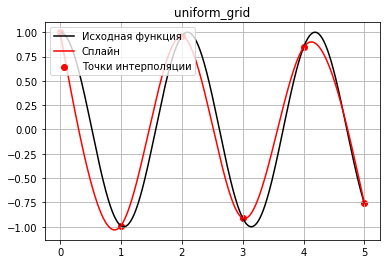

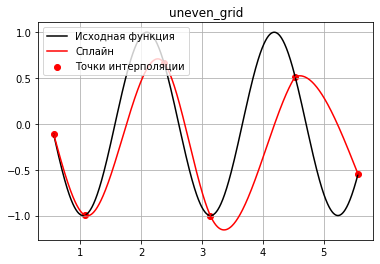

In [83]:
func = lambda x : np.cos(3.0 * x)

uniform_grid = np.linspace(0, 5, 6)
uneven_grid = np.array([uniform_grid[i] + stats.uniform.rvs() for i in range(len(uniform_grid))])

test(uniform_grid, func, 'uniform_grid')
test(uneven_grid, func, 'uneven_grid')
